<a href="https://colab.research.google.com/github/sjoon0305/KSME2026/blob/main/4. Nondimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem setup
Distributed load $f$가 작용하는 길이 $L$인 cantilever beam의 governing equation:
$$EI\frac{\partial^{4} u}{\partial x^4} = -f, \qquad x \in [0, L],$$
Boundary conditions:
$$u''(L)=0,   u'''(L)=0$$
$$u(0)=0,  u'(0)=0$$

Exact solution:
$$u(x) = -\frac{f}{24EI}(x^4 - 4Lx^3 + 6L^2 x^2)$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Network(torch.nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.layer1 = nn.Sequential(
      nn.Linear(1, 50),
      nn.Tanh(),
      nn.Linear(50, 50),
      nn.Tanh(),
      nn.Linear(50, 50),
      nn.Tanh(),
      nn.Linear(50, 1)
    )

  def forward(self, x):
    x = self.layer1(x)
    return x
  
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)

In [2]:
# Case 1
L = 1 # (m)
f = 1 # (N/m)
E = 1 # Pa
I = 1 # (m^2)
EI = E*I

def pde_loss(model, x):
  y_pred = model(x)
  y_t = torch.autograd.grad(y_pred.sum(), x, create_graph=True)[0]
  y_tt = torch.autograd.grad(y_t.sum(), x, create_graph=True)[0]
  y_ttt = torch.autograd.grad(y_tt.sum(), x, create_graph=True)[0]
  y_tttt = torch.autograd.grad(y_ttt.sum(), x, create_graph=True)[0]
  loss = (EI*y_tttt + f).pow(2).mean()
  return loss

def bc_loss1(model, x_bc):
  y_pred = model(x_bc)
  y_t = torch.autograd.grad(y_pred.sum(), x_bc, create_graph=True)[0]
  loss = y_pred.pow(2) + y_t.pow(2)
  return loss

def bc_loss2(model, x_bc):
  y_pred = model(x_bc)
  y_t = torch.autograd.grad(y_pred.sum(), x_bc, create_graph=True)[0]
  y_tt = torch.autograd.grad(y_t.sum(), x_bc, create_graph=True)[0]
  y_ttt = torch.autograd.grad(y_tt.sum(), x_bc, create_graph=True)[0]
  loss = y_tt.pow(2) + y_ttt.pow(2)
  return loss

def y_exact(x):
  return -1/24*x**4 + 1/6*x**3 - 1/4*x**2

# Collocation & Boundary Points
x_domain = [0., 1.]
x = torch.rand((100,1))*x_domain[1]
x = x.requires_grad_().to(device)
x_bc1 = torch.tensor([0.], device=device, requires_grad=True)
x_bc2 = torch.tensor([1.], device=device, requires_grad=True)

model = Network().to(device)
model.apply(init_weights)
# torch.optim.Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 3000
for epoch in range(n_epochs):
  pde_res = pde_loss(model, x)
  bound_loss1 = bc_loss1(model, x_bc1)
  bound_loss2 = bc_loss2(model, x_bc2)
  loss = pde_res + 30*bound_loss1 + bound_loss2

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch%1000 ==0:
    print(f'Epoch: {epoch}, Loss: {float(loss):.2}')

Epoch: 0, Loss: 5.8
Epoch: 1000, Loss: 0.0012
Epoch: 2000, Loss: 0.00048


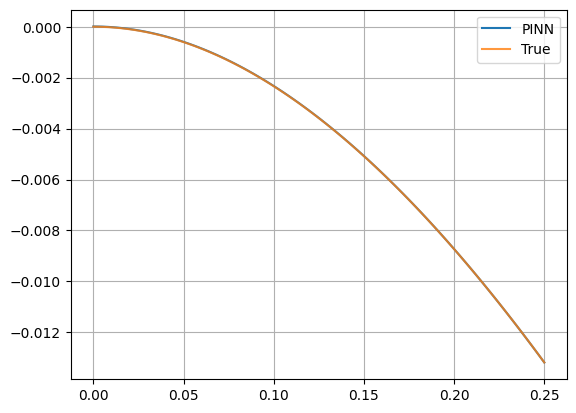

In [3]:
# Case 1 Validation
x_test = torch.from_numpy(np.linspace(0,0.25,100)).to(device).type(torch.float32)[:,None]
y_test = model(x_test)

x_true = np.linspace(0,0.25,100)
y_true = y_exact(x_true)

plt.figure()
plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy())
plt.plot(x_true, y_true, alpha=0.8)
plt.legend(['PINN','True'])
plt.grid()
plt.show()

In [12]:
# Case 2
L = 3. # (m)
f = 50.e3 # (N/m)
E = 200.e6 # Pa
I = 3 # (m^2)
EI = E*I

def pde_loss(model, x):
  y_pred = model(x)
  y_t = torch.autograd.grad(y_pred.sum(), x, create_graph=True)[0]
  y_tt = torch.autograd.grad(y_t.sum(), x, create_graph=True)[0]
  y_ttt = torch.autograd.grad(y_tt.sum(), x, create_graph=True)[0]
  y_tttt = torch.autograd.grad(y_ttt.sum(), x, create_graph=True)[0]
  loss = (EI*y_tttt + f).pow(2).mean()
  return loss

def bc_loss1(model, x_bc):
  y_pred = model(x_bc)
  y_t = torch.autograd.grad(y_pred.sum(), x_bc, create_graph=True)[0]
  loss = y_pred.pow(2) + y_t.pow(2)
  return loss

def bc_loss2(model, x_bc):
  y_pred = model(x_bc)
  y_t = torch.autograd.grad(y_pred.sum(), x_bc, create_graph=True)[0]
  y_tt = torch.autograd.grad(y_t.sum(), x_bc, create_graph=True)[0]
  y_ttt = torch.autograd.grad(y_tt.sum(), x_bc, create_graph=True)[0]
  loss = y_tt.pow(2) + y_ttt.pow(2)
  return loss

def y_exact(x):
  return -f/24/EI*(x**4 - 4*L*x**3 + 6*(L*x)**2)

# Collocation & Boundary Points
x_domain = [0., L]
x = torch.rand((100,1))*x_domain[1]
x = x.requires_grad_().to(device)
x_bc1 = torch.tensor([0.], device=device, requires_grad=True)
x_bc2 = torch.tensor([L], device=device, requires_grad=True)

model = Network().to(device)
model.apply(init_weights)
# torch.optim.Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 3000
for epoch in range(n_epochs):
  pde_res = pde_loss(model, x)
  bound_loss1 = bc_loss1(model, x_bc1)
  bound_loss2 = bc_loss2(model, x_bc2)
  loss = pde_res + 30*bound_loss1 + bound_loss2

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch%2000 ==0:
    print(f'Epoch: {epoch}, Loss: {float(loss):.2}')

Epoch: 0, Loss: 1.2e+16
Epoch: 2000, Loss: 1.2e+09


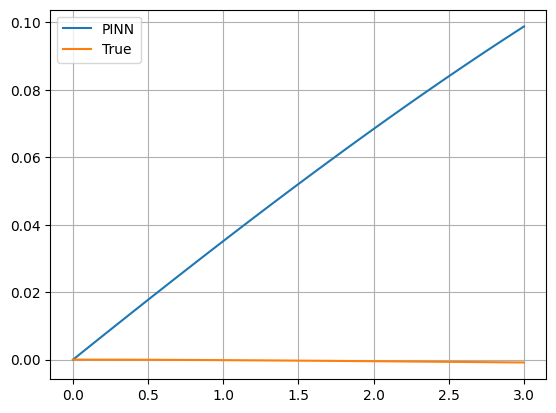

In [13]:
# Validation
x_test = torch.from_numpy(np.linspace(0,L,100)).to(device).type(torch.float32)[:,None]
y_test = model(x_test)

x_true = np.linspace(0, L, 100)
y_true = y_exact(x_true)

plt.figure()
plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy())
plt.plot(x_true, y_true)
plt.legend(['PINN', 'True'])
plt.grid()
plt.show()

# Nondimensionalization
Nondimensionalized governing equation:
$$\frac{\partial^{4} u}{\partial x^4} = -1, \qquad x \in [0, L/L_c],$$
Boundary conditions:
$$u''(L/L_c)=0,   u'''(L/L_c)=0$$
$$u(0)=0,  u'(0)=0$$

Exact solution:
$$u(x) = \frac{1}{24}x^4 - \frac{L}{6L_c}x^3 + \frac{3L^2}{4L_c^2}x^2$$

In [37]:
# Nondimensionalization
L_c = (EI/f)**(1/4) # Characteristic Length
x_end_nd = L/L_c

In [38]:
def nondim_pde_loss(model, x):
  y_pred = model(x)
  y_t = torch.autograd.grad(y_pred.sum(), x, create_graph=True)[0]
  y_tt = torch.autograd.grad(y_t.sum(), x, create_graph=True)[0]
  y_ttt = torch.autograd.grad(y_tt.sum(), x, create_graph=True)[0]
  y_tttt = torch.autograd.grad(y_ttt.sum(), x, create_graph=True)[0]
  loss = (y_tttt + 1).pow(2).mean()
  return loss

def y_nd_exact(x):
  return -1/24*x**4 + L/6/L_c*x**3 - 1/4*(L/L_c)**2*x**2

In [39]:
# Collocation & Boundary Points
x_domain_nd = [0., x_end_nd]
x_nd = torch.rand((100,1))*x_domain_nd[1]
x_nd = x_nd.requires_grad_().to(device)
x_bc1_nd = torch.tensor([0.], device=device, requires_grad=True)
x_bc2_nd = torch.tensor([x_end_nd], device=device, requires_grad=True)

In [43]:
model_nd = Network().to(device) # Nondimensionalized model
model_nd.apply(init_weights)
optimizer = torch.optim.Adam(model_nd.parameters(), lr=0.001)

n_epochs = 3000
for epoch in range(n_epochs):
  pde_res = nondim_pde_loss(model_nd, x_nd)
  bound_loss1 = bc_loss1(model_nd, x_bc1_nd)
  bound_loss2 = bc_loss2(model_nd, x_bc2_nd)
  loss = pde_res + 100*bound_loss1 + bound_loss2

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch%1000 ==0:
    print(f'Epoch: {epoch}, Loss: {float(loss):.2}')

Epoch: 0, Loss: 1.6
Epoch: 1000, Loss: 0.0027
Epoch: 2000, Loss: 8.3e-05


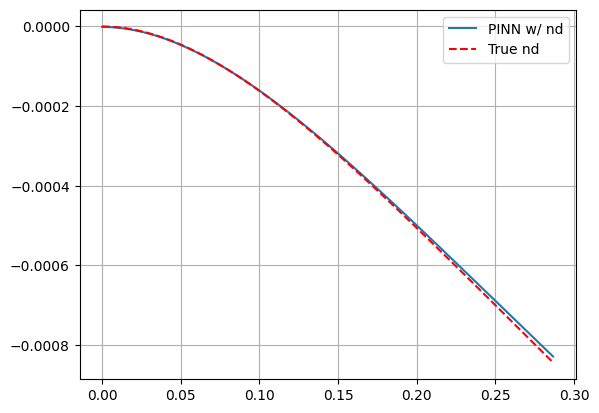

In [44]:
# Validation
x_test_nd = torch.from_numpy(np.linspace(0, x_end_nd, 100)).to(device).type(torch.float32)[:,None]
y_test_nd = model_nd(x_test_nd)

x_true_nd = np.linspace(0, x_end_nd, 100)
y_true_nd = y_nd_exact(x_true_nd)

plt.figure()
plt.plot(x_test_nd.detach().cpu().numpy(), y_test_nd.detach().cpu().numpy())
plt.plot(x_true_nd, y_true_nd, 'r--' )
plt.legend(['PINN w/ nd', 'True nd'])
plt.grid()
plt.show()

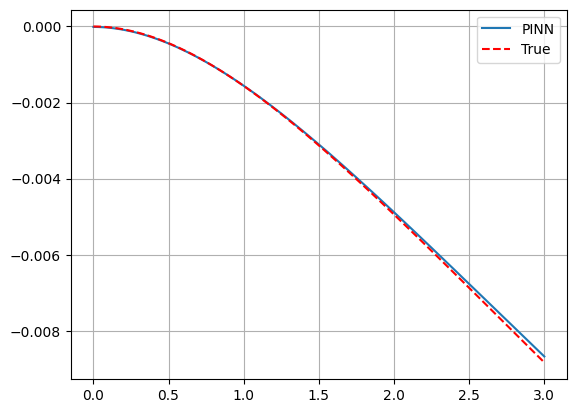

In [45]:
# Back to original scale
x_test_redim = x_test_nd*L_c
y_test_redim = y_test_nd*L_c

x_true_redim = x_true_nd*L_c
y_true_redim = y_true_nd*L_c

plt.figure()
plt.plot(x_test_redim.detach().cpu().numpy(), y_test_redim.detach().cpu().numpy())
plt.plot(x_true_redim, y_true_redim, 'r--')
plt.legend(['PINN', 'True'])
plt.grid()
plt.show()
